In [1]:
# Changing the working directory
import os
abspath = os.path.abspath("./src")
dname = os.path.dirname(abspath)
os.chdir(dname)

# Dependencies

In [2]:
from manim import *

import numpy as np
import pandas as pd
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
import sentencepiece as spm
plt.style.use('dark_background')

Manim Community v0.18.0.post0

In [3]:
from src.processing import src_processing
from src.transformer import Transformer

from utils import to_tokens, animate_emb, show_emb, animate_attn

# Introduction

## Motivation

In [4]:
%%manim -qk -v WARNING Motivation

class Motivation(Scene):
    def construct(self):
        # Transformer Sketch
        transformer_text = Text("Transformer").scale(1)
        transformer_box = SurroundingRectangle(transformer_text, buff=MED_SMALL_BUFF, color=WHITE)
        self.play(Create(transformer_box), Write(transformer_text))
        self.wait(1)

        # Input Prompt
        input_prompt = Tex("Transformers were designed for language translation.").scale(0.5).next_to(transformer_box, UP).shift(0.25*UP)
        self.play(Write(input_prompt))
        self.wait(1)
        self.play(FadeOut(input_prompt, target_position=transformer_box), ScaleInPlace(VGroup(transformer_box, transformer_text), scale_factor=1.5))
        self.wait(1)

        # Model Output
        output = Tex("Transformer wurden für die Sprachübersetzung entwickelt.").scale(0.5).next_to(transformer_box, DOWN).shift(0.25*DOWN)
        self.play(Write(output), ScaleInPlace(VGroup(transformer_box, transformer_text), 1/1.5))
        self.wait(1)
        self.play(FadeOut(output, transformer_text, transformer_box))
        self.wait(1)


        # Transition
        title = Title("Neural Machine Translation")
        self.play(Write(title))
        self.wait(1)

        # Encoder
        encoder_text = Tex("Encoder").scale(1).shift(3*LEFT+1.5*DOWN)
        encoder_box = SurroundingRectangle(encoder_text, color=ORANGE, buff=MED_SMALL_BUFF, fill_opacity=0.15)
        self.play(Create(encoder_box), Write(encoder_text))
        input_text = Tex("Transformers were designed for language translation").scale(0.45).next_to(encoder_box, DOWN).shift(0.5*DOWN)
        intxt2enc = Line(input_text.get_edge_center(UP)+0.05*UP, encoder_box.get_edge_center(DOWN)+0.05*DOWN, color=WHITE)
        
        encoded_text = Tex("Transformers", " were", " designed" , " for", " language", " translation").scale(0.45).next_to(encoder_box, UP).shift(0.5*UP)
        encoded_text.set_color_by_tex('Transformers', RED_A)
        encoded_text.set_color_by_tex('designed', RED_A)
        encoded_text.set_color_by_tex('language', GREEN_A)
        encoded_text.set_color_by_tex('translation', GREEN_A)
        enc2outtxt = Line(encoder_box.get_edge_center(UP)+0.05*UP, encoded_text.get_edge_center(DOWN)+0.05*DOWN, color=WHITE)

        # Decoder
        decoder_text = Tex("Decoder").scale(1).next_to(encoded_text, RIGHT).shift(2*RIGHT)
        decoder_box = SurroundingRectangle(decoder_text, color=BLUE_B, buff=MED_SMALL_BUFF, fill_opacity=0.15)
        self.play(Create(decoder_box), Write(decoder_text))
        self.wait(1)
        self.play(Write(input_text))
        self.wait(1)
        self.play(Create(intxt2enc))
        self.wait(1)
        self.play(Create(enc2outtxt))
        self.wait(1)
        self.play(Write(encoded_text))
        self.wait(1)


        outtxt2dec = Line(encoded_text.get_edge_center(RIGHT)+0.05*RIGHT, decoder_box.get_edge_center(LEFT)+0.05*LEFT, color=BLUE_A)
        self.play(Create(outtxt2dec))

        decoder_input = Tex("[BOS]", " Transformer", " wurden", " für", " die", " Sprachübersetzung", " entwickelt").scale(0.45).next_to(decoder_box, DOWN).shift(0.5*DOWN)
        decoder_input_box = SurroundingRectangle(decoder_input, color=WHITE, buff=MED_SMALL_BUFF)
        decoder_in_text_connect = Line(decoder_input_box.get_edge_center(UP)+0.05*UP, decoder_box.get_edge_center(DOWN)+0.05*DOWN, color=WHITE)
        decoder_output = Tex(" Transformer", " wurden", " für", " die", " Sprachübersetzung", " entwickelt", " [EOS]").scale(0.45).next_to(decoder_box, UP).shift(0.5*UP)
        decoder_output_box = SurroundingRectangle(decoder_output, color=WHITE, buff=MED_SMALL_BUFF)
        decoder_out_text_connect = Line(decoder_box.get_edge_center(UP)+0.05*UP, decoder_output_box.get_edge_center(DOWN)+0.05*DOWN, color=WHITE)
        self.play(Create(decoder_input_box), Create(decoder_output_box), Create(decoder_in_text_connect), Create(decoder_out_text_connect))
        self.wait(1)
        for i in range(7):
            self.play(Write(decoder_input[i]))
            if i > 0:
                self.play(FadeOut(connection))
            self.play(Write(decoder_output[i]))
            if i < 6:
                connection = CurvedArrow(decoder_output_box.get_edge_center(RIGHT)+0.05*RIGHT, decoder_input_box.get_edge_center(RIGHT)+0.05*RIGHT, angle=-1.5707963267948966)
                self.play(Create(connection))
        self.wait(1)

        # Transition
        fade_out_animations = [FadeOut(obj) for obj in self.mobjects if obj != title]
        self.play(AnimationGroup(*fade_out_animations))
        self.wait(1)

        # Loading Dataset
        df = pd.read_csv("../data/shk2mod.csv", index_col=0)                           
        df.drop("id", axis=1, inplace=True)                                  
        d = df.to_numpy()
        src, trg = d[:,0], d[:,1]

        # Showcasing dataset
        sk_stns = VGroup(Tex(src[0]))
        md_stns = VGroup(Tex(trg[0]))
        np.random.seed(0)
        idx = np.random.randint(1, len(src), 7)
        for i in range(7):
            if i != 3:
                # Shakespeare sentence
                sk_stn = Tex(src[idx[i]]).next_to(sk_stns[-1], DOWN).shift(0.25*DOWN)
                sk_stns.add(sk_stn)
                # Modern sentence
                md_stn = Tex(trg[idx[i]]).next_to(md_stns[-1], DOWN).shift(0.25*DOWN)
                md_stns.add(md_stn)
            else:
                # Shakespeare vdots
                sk_vdots = Tex(r"\vdots").next_to(sk_stns[-1], DOWN).shift(0.25*DOWN)
                sk_stns.add(sk_vdots)
                # Modern English vdots
                md_vdots = Tex(r"\vdots").next_to(md_stns[-1], DOWN).shift(0.25*DOWN)
                md_stns.add(md_vdots)

        sk_stns = sk_stns.scale(0.35).next_to(title, DOWN).shift(DOWN).to_edge(LEFT)
        sk_stns_box = SurroundingRectangle(sk_stns, color=RED)
        md_stns = md_stns.scale(0.35).next_to(title, DOWN).shift(DOWN).to_edge(RIGHT)
        md_stns_box = SurroundingRectangle(md_stns, color=BLUE)

        self.play(Create(sk_stns_box), Write(sk_stns))
        self.wait(1)

        self.play(Create(md_stns_box), Write(md_stns))
        self.wait(1)
        
        fade_out_animations = [FadeOut(obj) for obj in self.mobjects]
        self.play(AnimationGroup(*fade_out_animations))
        self.wait(1)

        return super().construct()

## Overview

In [5]:
%%manim -qk -v WARNING Overview

class Overview(Scene):
    def construct(self):
        # Transition
        screen = Rectangle(height=7, width=13.3)
        self.play(Create(screen))
        self.wait(1)

        # Tokenization & Numericalization
        df = pd.read_csv("../data/shk2mod.csv", index_col=0)
        df.drop("id", axis=1, inplace=True)                                  
        d = df.to_numpy()
        src = d[0,0]
        shakespeare = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/shakespeare_en.model")
        src_stn = Tex(src).scale(0.75)
        src_toks = [piece.lstrip('▁') for piece in shakespeare.EncodeAsPieces(src)]
        src_toks_ = VGroup(Tex(src_toks[0]))
        src_toks_.add(SurroundingRectangle(src_toks_[-1], buff=0.25))
        for tok in src_toks[1:]:
            src_toks_.add(Tex(tok).next_to(src_toks_[-1], RIGHT).shift(0.15*RIGHT))
            src_toks_.add(SurroundingRectangle(src_toks_[-1], buff=0.25))
        src_toks = src_toks_.scale(0.75).move_to(ORIGIN)
        self.play(Write(src_stn))
        self.wait(1)
        self.play(ReplacementTransform(src_stn, src_toks))
        src_ids = shakespeare.EncodeAsIds(src)
        for (i,id) in enumerate(src_ids):
            src_id = Tex(id).scale(0.75).move_to(src_toks[i*2])
            self.play(ReplacementTransform(src_toks[i*2], src_id))
            src_toks[i*2] = src_id
        self.wait(1)

        # Token Embedding & Positional Encoding
        self.play(VGroup(src_toks).animate.scale(0.65).shift(2.75*DOWN))
        tok_emb_text = Tex("Token Embedding").scale(0.5).next_to(src_toks, UP).shift(0.25*UP)
        tok_emb_box = SurroundingRectangle(tok_emb_text, color=RED_A, buff=MED_SMALL_BUFF, fill_opacity=0.15)
        self.play(Create(tok_emb_box), Write(tok_emb_text))
        self.wait(1)
        pos_enc_text = Tex("Positional Encoding").scale(0.5).next_to(tok_emb_box, UP).shift(0.15*UP)
        pos_enc_box = SurroundingRectangle(pos_enc_text, color=GREEN_A, buff=MED_SMALL_BUFF, fill_opacity=0.15)
        self.play(Create(pos_enc_box), Write(pos_enc_text))
        self.wait(10)

        self.play(FadeOut(tok_emb_text, tok_emb_box, pos_enc_text, pos_enc_box, src_toks, src_id))
        self.wait(2)

        # Encoder
        encoder_text = Tex("Encoder").scale(1)
        encoder_box = SurroundingRectangle(encoder_text, color=ORANGE, buff=MED_SMALL_BUFF, fill_opacity=0.15)
        self.play(Create(encoder_box), Write(encoder_text))
        self.wait(1)
        encoder_box_ = Rectangle(height=5, width=5, color=ORANGE, fill_opacity=0.15)
        input_text = Tex("You do not meet a man but frowns:").scale(0.45).next_to(encoder_box_, LEFT)
        self.play(encoder_text.animate.move_to(encoder_box_.get_edge_center(UP)).shift(0.25*UP), ReplacementTransform(encoder_box, encoder_box_))
        self.play(Write(input_text))
        output_text = Tex("You", " do not", " meet", " a man", " but", " frowns", ":").scale(0.45).next_to(encoder_box_, RIGHT)
        output_text.set_color_by_tex('You', RED_A)
        output_text.set_color_by_tex('meet', RED_A)
        output_text.set_color_by_tex('man', GREEN_A)
        output_text.set_color_by_tex('frowns', GREEN_A)
        self.play(Write(output_text))
        self.wait(1)
        self.wait(5)
        self.play(FadeOut(encoder_text, encoder_box_, input_text, output_text))
        self.wait(2)

        # Decoder
        encoded_text = Tex("You", " do not", " meet", " a man", " but", " frowns", ":").scale(0.45).shift(4*LEFT)
        encoded_text.set_color_by_tex('You', RED_A)
        encoded_text.set_color_by_tex('meet', RED_A)
        encoded_text.set_color_by_tex('man', GREEN_A)
        encoded_text.set_color_by_tex('frowns', GREEN_A)
        self.play(Write(encoded_text))
        self.wait(1)

        decoder_text = Tex("Decoder").scale(1)
        decoder_box = SurroundingRectangle(decoder_text, color=BLUE_B, buff=MED_SMALL_BUFF, fill_opacity=0.15)
        self.play(Create(decoder_box), Write(decoder_text))
        self.wait(1)

        encoder_text_connect = Line(encoded_text.get_edge_center(RIGHT)+0.05*RIGHT, decoder_box.get_edge_center(LEFT)+0.05*LEFT, color=BLUE_A)
        self.play(Create(encoder_text_connect))
        self.wait(1)

        decoder_input = Tex("[BOS]", " Every", " man", " you", " meet", " these", " days", " is", " frowning").scale(0.45).next_to(decoder_box, DOWN).shift(0.5*DOWN)
        decoder_input_box = SurroundingRectangle(decoder_input, color=WHITE, buff=MED_SMALL_BUFF)
        decoder_in_text_connect = Line(decoder_input_box.get_edge_center(UP)+0.05*UP, decoder_box.get_edge_center(DOWN)+0.05*DOWN, color=WHITE)
        decoder_output = Tex(" Every", " man", " you", " meet", " these", " days", " is", " frowning", " [EOS]").scale(0.45).next_to(decoder_box, UP).shift(0.5*UP)
        decoder_output_box = SurroundingRectangle(decoder_output, color=WHITE, buff=MED_SMALL_BUFF)
        decoder_out_text_connect = Line(decoder_box.get_edge_center(UP)+0.05*UP, decoder_output_box.get_edge_center(DOWN)+0.05*DOWN, color=WHITE)
        self.play(Create(decoder_input_box), Create(decoder_output_box), Create(decoder_in_text_connect), Create(decoder_out_text_connect))
        self.wait(1)
        for i in range(9):
            self.play(Write(decoder_input[i]))
            if i > 0:
                self.play(FadeOut(connection))
            self.play(Write(decoder_output[i]))
            if i < 8:
                connection = CurvedArrow(decoder_output_box.get_edge_center(RIGHT)+0.05*RIGHT, decoder_input_box.get_edge_center(RIGHT)+0.05*RIGHT, angle=-1.5707963267948966)
                self.play(Create(connection))
        self.wait(1)
        self.play(FadeOut(encoded_text, decoder_text, decoder_box, 
                        encoder_text_connect, decoder_input, decoder_input_box, 
                        decoder_output, decoder_output_box, decoder_in_text_connect, 
                        decoder_out_text_connect))
        self.wait(1)

        closing_text = Tex("Let's get started...")
        self.play(ReplacementTransform(screen, closing_text))
        self.wait(2)
        self.play(FadeOut(closing_text))
        self.wait(1)

### Token Embedding and Positional Encoding

Src Shapes: torch.Size([1, 256]); dtype: torch.int64


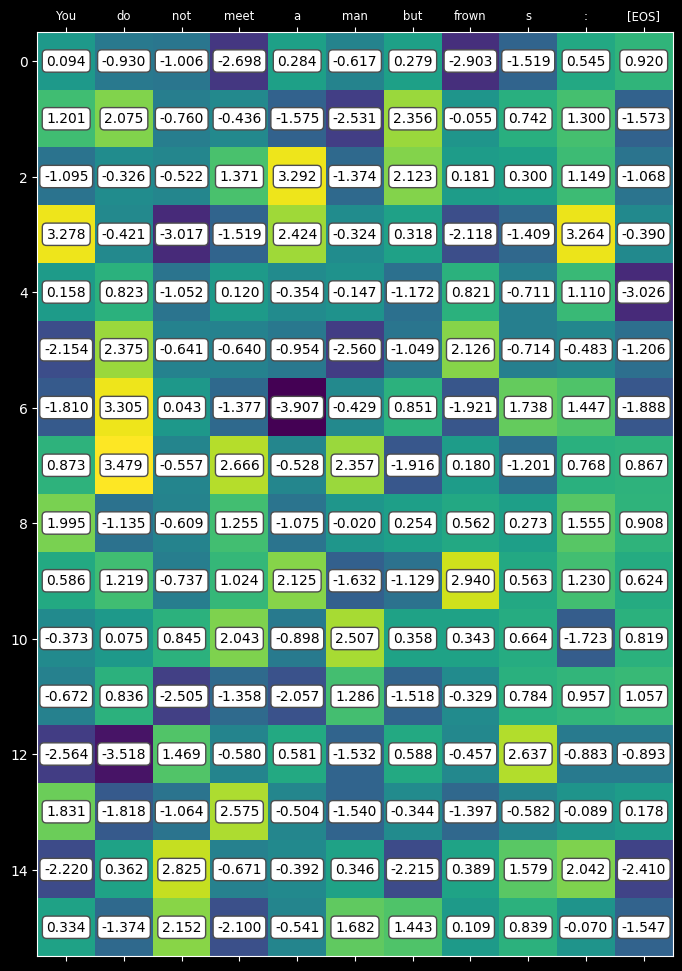

In [39]:
# Loading Tokenizers
shakespeare = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/shakespeare_en.model")
modern = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/modern_en.model")

model = Transformer(emb=256, heads=8, max_seq_len=256, 
                    src_vocab_len=shakespeare.vocab_size(), trg_vocab_len=modern.vocab_size(),
                    num_layers=2)
model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep0.pt", map_location=torch.device('cpu')))

# Example Sentence
df = pd.read_csv("../data/shk2mod.csv", index_col=0)                           
df.drop("id", axis=1, inplace=True)                                  
d = df.to_numpy()
src_toy = d[0:1,0] #["What, art thou mad?"]

# Encoding src
src_id_toy = shakespeare.EncodeAsIds(list(src_toy))
src_id_toy = [src_processing(id, 256) for id in src_id_toy] 

# Tokenized src
src_toy_tok = to_tokens(src_toy, shakespeare, 256, "src")

# Moving everything to torch tensors
src_id_toy = torch.tensor(src_id_toy)

print("Src Shapes: {}; dtype: {}".format(src_id_toy.shape, src_id_toy.dtype))

plt.rcParams["figure.figsize"] = (12,12)

# Embeddings over time
src_embs = []

for i in range(200):
    # Embeddings as the model is trained
    src_embs.append(model.src_token_emb(src_id_toy)+ model.src_pos_emb(torch.arange(256, device="cpu")))

# Embeddings over time
for i in range(0, 455):
    model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep{}.pt".format(i), map_location=torch.device('cpu')))

    # Embeddings as the model is trained
    src_embs.append(model.src_token_emb(src_id_toy)+ model.src_pos_emb(torch.arange(256, device="cpu")))

for i in range(200):
    # Embeddings as the model is trained
    src_embs.append(model.src_token_emb(src_id_toy)+ model.src_pos_emb(torch.arange(256, device="cpu")))


# Create the animation
ani = animate_emb(src_embs, src_toy_tok, 11)

# Save the animation
ani.save('./media/videos/animations/TokEmb_PosEnc.mp4', writer='ffmpeg', fps=60, dpi=300)

### Encoder

Src Shapes: torch.Size([1, 256]); dtype: torch.int64


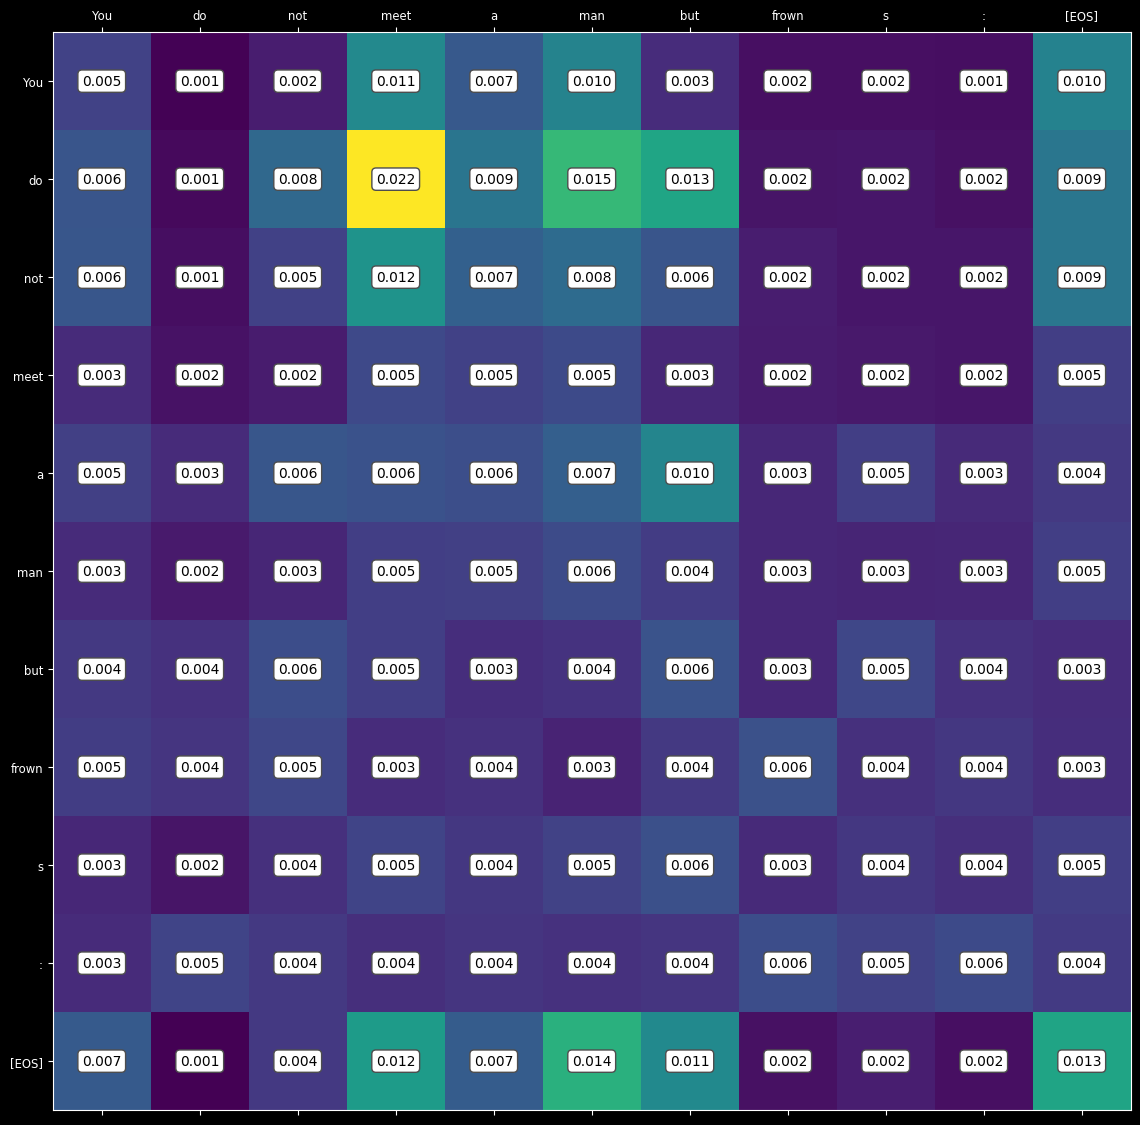

In [5]:
# Loading Tokenizers
shakespeare = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/shakespeare_en.model")
modern = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/modern_en.model")

model = Transformer(emb=256, heads=8, max_seq_len=256, 
                    src_vocab_len=shakespeare.vocab_size(), trg_vocab_len=modern.vocab_size(),
                    num_layers=2)
model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep0.pt", map_location=torch.device('cpu')))

# Example Sentence
df = pd.read_csv("../data/shk2mod.csv", index_col=0)                           
df.drop("id", axis=1, inplace=True)                                  
d = df.to_numpy()
src_toy = d[0:1,0] #["What, art thou mad?"]

# Encoding src
src_id_toy = shakespeare.EncodeAsIds(list(src_toy))
src_id_toy = [src_processing(id, 256) for id in src_id_toy] 

# Tokenized src
src_toy_tok = to_tokens(src_toy, shakespeare, 256, "src")

# Moving everything to torch tensors
src_id_toy = torch.tensor(src_id_toy)

print("Src Shapes: {}; dtype: {}".format(src_id_toy.shape, src_id_toy.dtype))

plt.rcParams["figure.figsize"] = (14,14)

# Embeddings over time
src_attns = []

for i in range(0, 200):
    model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep{}.pt".format(0), map_location=torch.device('cpu')))

    # Embeddings as the model is trained
    src_emb = model.src_token_emb(src_id_toy)+ model.src_pos_emb(torch.arange(256, device="cpu"))
    attn_layer = model.encoder[0].self_attention
    src_attn = attn_layer(model.encoder[0].norm1(src_emb))
    attn_w = attn_layer.attention_weights[0]
    src_attns.append(attn_w)

# Embeddings over time
for i in range(0, 455):
    model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep{}.pt".format(i), map_location=torch.device('cpu')))

    # Embeddings as the model is trained
    src_emb = model.src_token_emb(src_id_toy)+ model.src_pos_emb(torch.arange(256, device="cpu"))
    attn_layer = model.encoder[0].self_attention
    src_attn = attn_layer(model.encoder[0].norm1(src_emb))
    attn_w = attn_layer.attention_weights[0]
    src_attns.append(attn_w)

for i in range(0, 200):
    # Embeddings as the model is trained
    src_emb = model.src_token_emb(src_id_toy)+ model.src_pos_emb(torch.arange(256, device="cpu"))
    attn_layer = model.encoder[0].self_attention
    src_attn = attn_layer(model.encoder[0].norm1(src_emb))
    attn_w = attn_layer.attention_weights[0]
    src_attns.append(attn_w)


# Create the animation
ani = animate_attn(src_attns, src_toy_tok, 11)

# Save the animation
ani.save('./media/videos/animations/Encoder_.mp4', writer='ffmpeg', fps=60, dpi=300)